In [1]:
import cv2
import numpy as np

In [2]:
import copy

# 포인터를 공유 -> malloc을 통해 해결(C, C++ 관점)
# 객체를 공유 -> new를 통해 해결(자바 관점)
# 파이썬에서 위의 역할을 해주는 것이 copy.deepcopy()
def filter_2d(input_img, kernel):
    input_img = copy.deepcopy(input_img)
    output_img = copy.deepcopy(input_img)
    
    #print('input_img.shape[0]:', input_img.shape[0])
    #print('input_img.shape[1]:', input_img.shape[1])
    
    #for i in range(input_img.shape[0]):
    #    print(input_img[i])
        
    # 컨벌루션 연산이 적용되는 대상은 무엇인가 ? 답: 이미지
    # 이미지 -> (다차원)행렬
    for row in range(input_img.shape[0]):
        output_img[row][0] = input_img[row][1] * kernel[0] + \
                        input_img[row][0] * kernel[1] + \
                        input_img[row][1] * kernel[2]
        
        for col in range(1, input_img.shape[1] - 1):
            output_img[row][col] = input_img[row][col - 1] * kernel[0] + \
                        input_img[row][col] * kernel[1] + \
                        input_img[row][col + 1] * kernel[2]
            
        output_img[row][input_img.shape[1] - 1] = \
            input_img[row][input_img.shape[1] - 2] * kernel[0] + \
            input_img[row][input_img.shape[1] - 1] * kernel[1] + \
            input_img[row][input_img.shape[1] - 2] * kernel[2]
            
    return output_img.T

In [3]:
# 윈도우 = keras 앞부분에 tensorflow를 붙여줘야한다.
# 우분투 = 앞에 붙일 필요 없이 keras만 작성해도 된다.
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [4]:
classifier = VGG16()

In [5]:
# 마지막 레이어를 제거하여 추가적인 네트워크 구성이 가능하게 만든다.
last_layer = str(classifier.layers[-1])

In [6]:
# 윈도우는 앞에 tensorflow. 붙이기 / 우분투는 tensorflow. 없어도 된다.
import tensorflow.keras

from tensorflow.keras.layers import Dense

In [7]:
# 추가할 신규 레이어를 작성하는 파트
new_layer = tensorflow.keras.Sequential()

for layer in classifier.layers:
    if str(layer) != last_layer:
        new_layer.add(layer)
        
new_layer.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [8]:
# 네트워크를 동결시키도록 한다.
for layer in new_layer.layers:
    layer.trainable = False

In [9]:
new_layer.add(
    Dense(128, activation = 'relu')
)
new_layer.add(
    Dense(64, activation = 'relu')
)
new_layer.add(
    Dense(32, activation = 'relu')
)
new_layer.add(
    Dense(16, activation = 'relu')
)
new_layer.add(
    Dense(1, activation = 'sigmoid')
)

new_layer.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [10]:
new_layer.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
train_gen = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_gen = ImageDataGenerator(rescale = 1.0 / 255)

In [13]:
trainSet = train_gen.flow_from_directory(
    'C:/Users/wanni/Desktop/' +
    'Applied-Deep-Learning-with-Keras/Lesson07/' +
    'Datasets/dataset/training_set',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)
testSet = test_gen.flow_from_directory(
    'C:/Users/wanni/Desktop/' +
    'Applied-Deep-Learning-with-Keras/Lesson07/' +
    'Datasets/dataset/test_set',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [14]:
batch_size = 100

new_layer.fit_generator(
    trainSet,
    steps_per_epoch = int(10000/batch_size),
    epochs = 10,
    validation_data = testSet,
    validation_steps = int(2500/batch_size)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
 49/100 [=============>................] - ETA: 1:34 - loss: 0.6642 - accuracy: 0.6199

C:\Users\wanni\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
C:\Users\wanni\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
C:\Users\wanni\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
C:\Users\wanni\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
C:\Users\wanni\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
C:\Users\wanni\anaconda3\lib\site-packages\PIL\TiffIma

100/100 [==============================] - 240s 2s/step - loss: 0.5504 - accuracy: 0.7097 - val_loss: 0.3475 - val_accuracy: 0.8587
Epoch 2/10
100/100 [==============================] - 244s 2s/step - loss: 0.3846 - accuracy: 0.8272 - val_loss: 0.3198 - val_accuracy: 0.8575
Epoch 3/10
100/100 [==============================] - 244s 2s/step - loss: 0.3570 - accuracy: 0.8334 - val_loss: 0.2651 - val_accuracy: 0.8938
Epoch 4/10
100/100 [==============================] - 246s 2s/step - loss: 0.3020 - accuracy: 0.8741 - val_loss: 0.2832 - val_accuracy: 0.8763
Epoch 5/10
100/100 [==============================] - 246s 2s/step - loss: 0.3008 - accuracy: 0.8700 - val_loss: 0.2413 - val_accuracy: 0.8850
Epoch 6/10
100/100 [==============================] - 246s 2s/step - loss: 0.3124 - accuracy: 0.8609 - val_loss: 0.3182 - val_accuracy: 0.8512
Epoch 7/10
100/100 [==============================] - 258s 3s/step - loss: 0.3113 - accuracy: 0.8628 - val_loss: 0.2708 - val_accuracy: 0.8925
Epoch 8/10

In [15]:
# 윈도우 [tensorflow.] 추가
from tensorflow.keras.applications.resnet50 import ResNet50

In [16]:
resModel = ResNet50()
resModel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [17]:
# 라플라스 변환을 하면 s-domain이라는 평면으로 이동을 하게 되고
# 라플라스 역변환을 하면 time-domaim(시간축)으로 돌아오게 된다.
from keras.applications.vgg16 import decode_predictions

In [18]:
# 여기에 flask 모델 추가하는곳으로 예상
# vue에서 flask, axios로 python으로 이미지를 받아온다.

In [ ]:
# import socket

# (host, port) = ('localhost', 37373)

# s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
# s.bind((host, port))
# s.listen(1)

# conn, addr = s.accept()

# with open('output', 'wb') as f:
# 	while True:
# 		l = conn.recv(1024)
# 		if not 1:
# 			break
# 		f.write(l)

# s.close()


In [1]:
# from flask import send_file
# from flask import Flask

# app = Flask(__name__)

# # RFC - https://tools.ietf.org/html/rfc3003
# @app.route('/jpg_download')
# def mp3_download():
#     file_name = "./TwoStepDR_320kbps.jpeg"
#     return send_file(file_name,
#                      mimetype='image/jpeg',
#                      attachment_filename='img_test.jpeg',# 다운받아지는 파일 이름. 
#                      as_attachment=True)

# @app.route("/file_download")
# def hello():
#     return '''
#     <a href="/jpg_download">Click me.</a>
    
#     <form method="get" action="jpg_download">
#         <button type="submit">Download!</button>
#     </form>
#     '''

# if __name__ == '__main__':
# 	app.run(debug=True)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with windowsapi reloader


SystemExit: 1

C:\Users\wanni\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


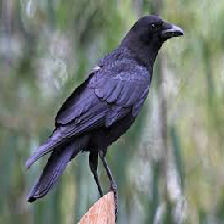

In [63]:
# 일단 테스트 용도로 다양한 모델을 검증해보자.
# 말그대로의 test 모델들을 넣어보자.
# 현재 이미지 7까지
test_A_img = image.load_img("test_image_11.jpg", target_size = (224, 224))
test_A_img

In [64]:
trans_img = image.img_to_array(test_A_img)
trans_img = np.expand_dims(trans_img, axis = 0)
trans_img = preprocess_input(trans_img)
print(trans_img.shape)

(1, 224, 224, 3)


In [65]:
pred = resModel.predict(trans_img)

In [66]:
label = decode_predictions(pred)

print('top 5!')

for i in range(5):
    print('%16s (%.2f%%)' % (label[0][i][1], label[0][i][2] * 100))

top 5!
          coucal (39.56%)
    black_grouse (21.77%)
           robin (6.96%)
      worm_fence (5.39%)
          bulbul (3.89%)


In [ ]:
# 분석 결과가 나왔으면 나온 결과를 vue로 연결해서 보여준다.